# Requirements

In [ ]:
!pip install wikipedia-api

# Import Dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/content/videos.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92759 entries, 0 to 92758
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   kind                  92759 non-null  object 
 1   videoId               92759 non-null  int64  
 2   publishedAt           92759 non-null  object 
 3   channelId             92759 non-null  int64  
 4   title                 92759 non-null  object 
 5   description           35237 non-null  object 
 6   tags                  20891 non-null  object 
 7   defaultLanguage       15785 non-null  object 
 8   defaultAudioLanguage  29956 non-null  object 
 9   contentDuration       91492 non-null  object 
 10  viewCount             91490 non-null  float64
 11  likeCount             86630 non-null  float64
 12  favouriteCount        91492 non-null  float64
 13  commentCount          90294 non-null  float64
 14  topicCategories       91228 non-null  object 
dtypes: float64(4), int6

In [ ]:
df.head()

,kind,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,likeCount,favouriteCount,commentCount,topicCategories
0,youtube#video,85806,2024-01-15 00:59:29+00:00,33807,Unlocking the Benefits of Face Masks for Skin ...,NaN,NaN,en-US,en-US,PT9S,72.0,0.0,0.0,0.0,"['https://en.wikipedia.org/wiki/Health', 'http..."
1,youtube#video,30556,2023-10-27 19:32:16+00:00,46650,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,NaN,NaN,NaN,NaN,PT45S,257.0,7.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
2,youtube#video,51771,2024-09-28 01:23:22+00:00,14346,#trending #makeup #beautymakeup #yslbeauty #lu...,NaN,NaN,NaN,en-US,PT19S,164.0,4.0,0.0,2.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
3,youtube#video,45298,2023-07-13 15:19:28+00:00,50139,#shortvedio #balayage,NaN,NaN,NaN,NaN,PT14S,1207.0,20.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
4,youtube#video,43611,2023-04-29 18:47:37+00:00,8143,Full Face of Merit Beauty 🤎 featuring new Flus...,NaN,NaN,NaN,en,PT56S,8647.0,268.0,0.0,7.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...


# Formatting and Cleaning

In [ ]:
print(df['kind'].unique())

df.drop('kind', axis=1, inplace=True)

['youtube#video']


In [ ]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

In [ ]:
from datetime import timedelta
import re

# Function to convert ISO 8601 duration string to total seconds
def convert_duration_to_seconds(duration_str):
    if not isinstance(duration_str, str):
        return None

    # Use regular expressions to find hours, minutes, and seconds
    hours = re.search(r'(\d+)H', duration_str)
    minutes = re.search(r'(\d+)M', duration_str)
    seconds = re.search(r'(\d+)S', duration_str)

    h = int(hours.group(1)) if hours else 0
    m = int(minutes.group(1)) if minutes else 0
    s = int(seconds.group(1)) if seconds else 0

    return timedelta(hours=h, minutes=m, seconds=s).total_seconds()

# Apply the conversion function to the 'contentDuration' column
df['contentDuration_seconds'] = df['contentDuration'].apply(convert_duration_to_seconds)

# Feature Generation

## 1. Topic Extraction and Wikipedia Enrichment

In [ ]:
# Extract the topic out from the Wikipedia URLs
import ast

def extract_topic_from_wiki(url_list):
    if pd.isna(url_list):
        return []

    # If it's a string that looks like a list, safely parse it
    if isinstance(url_list, str):
        try:
            parsed = ast.literal_eval(url_list)
            if isinstance(parsed, list):
                url_list = parsed
            else:
                url_list = [url_list]
        except Exception:
            url_list = [url_list]

    topics = []
    for url in url_list:
        if not isinstance(url, str):
            continue
        topic = url.split("/")[-1]              # take last part
        topic = topic.replace("_", " ").strip() # underscores → spaces
        topic = topic.strip("']")               # remove trailing ' or ]
        topics.append(topic)

    return topics

df['topicCleaned'] = df['topicCategories'].apply(extract_topic_from_wiki)

In [ ]:
#List all the unique topics/categories in this dataset
all_topics = set([t for sublist in df['topicCleaned'] for t in sublist if isinstance(sublist, list)])
print("Total unique topics:", len(all_topics))
print(sorted(all_topics))

Total unique topics: 45
['Action game', 'Action-adventure game', 'Basketball', 'Business', 'Casual game', 'Country music', 'Cricket', 'Electronic music', 'Entertainment', 'Fashion', 'Film', 'Food', 'Health', 'Hip hop music', 'Hobby', 'Humour', 'Jazz', 'Knowledge', 'Lifestyle (sociology)', 'Military', 'Mixed martial arts', 'Music', 'Music of Asia', 'Music of Latin America', 'Performing arts', 'Pet', 'Physical attractiveness', 'Physical fitness', 'Politics', 'Pop music', 'Puzzle video game', 'Religion', 'Rhythm and blues', 'Role-playing video game', 'Society', 'Soul music', 'Sport', 'Sports game', 'Strategy video game', 'Technology', 'Television program', 'Tennis', 'Tourism', 'Vehicle', 'Video game culture']


## 2. Like-View ratio, Comment-view Ratio

In [ ]:
df['like_view_ratio'] = np.where(df['viewCount']>0, df['likeCount'] / df['viewCount'], np.nan)
df['comment_view_ratio'] = np.where(df['viewCount']>0, df['commentCount'] / df['viewCount'], np.nan)

## 3. Video duration segmentation

In [ ]:
bins = [0, 30, 120, 300, 900, 3600, np.inf]
labels = ['<30s', '30-120s', '2-5m', '5-15m', '15-60m', '>60m']
try:
  df['length_bucket'] = pd.cut(df['contentDuration_seconds'].fillna(-1), bins=[-1,30,120,300,900,3600,10**9], labels=labels)
except Exception:
  df['length_bucket'] = 'unknown'

## 4. Tags Cleaning

In [ ]:
def extract_hashtags(text):
  if pd.isna(text):
    return []
  return re.findall(r"#(\w+)", str(text))

hashtags_from_title = df['title'].apply(extract_hashtags) if 'title' in df.columns else [[] for _ in range(len(df))]
hashtags_from_desc = df['description'].apply(extract_hashtags) if 'description' in df.columns else [[] for _ in range(len(df))]

def ensure_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    return [x]

merged_tags = []
for base, ht1, ht2 in zip(df['tags'], hashtags_from_title, hashtags_from_desc):
  base = ensure_list(base)
  ht1 = ensure_list(ht1)
  ht2 = ensure_list(ht2)
  merged = list(set(base) | set(ht1) | set(ht2))
  merged_tags.append(merged)


df['tags'] = merged_tags

In [ ]:
# Attempt to enrich dataset with more information from wikipedia
import wikipediaapi
import requests

import urllib.parse
from datetime import datetime

def get_wiki_pageviews(page_title, start="20230101", end=None):
    if end is None:
        # default to today's date in YYYYMMDD
        end = datetime.today().strftime("%Y%m%d")

    # Encode title properly for Wikimedia API
    encoded_title = urllib.parse.quote(page_title, safe="")

    url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/{encoded_title}/daily/{start}/{end}"
    r = requests.get(url)

    if r.status_code == 200:
        data = r.json().get("items", [])
        if data:
            return sum(item["views"] for item in data)
    return 0  # return 0 instead of None if no data

wiki_wiki = wikipediaapi.Wikipedia(user_agent="LoReal (ryanchinjh@gmail.com)", language='en')



def enrich_wiki_topic(topic_url):
    try:
        topic = topic_url.split("/")[-1]
        page_title = topic  # keep underscores
        page = wiki_wiki.page(topic.replace("_", " "))
        summary = page.summary[0:500] if page.exists() else None
        pageviews = get_wiki_pageviews(page_title)
        return {
            "topic": topic.replace("_", " "),
            #"summary": summary,
            "categories": list(page.categories.keys()) if page.exists() else [],
            "pageviews": pageviews
        }
    except Exception:
        return {"topic": None, "summary": None, "categories": [], "pageviews": 0}

print(enrich_wiki_topic("https://en.wikipedia.org/wiki/Lifestyle_(sociology)"))

{'topic': 'Lifestyle (sociology)', 'categories': ['Category:1920s neologisms', 'Category:Articles containing German-language text', 'Category:Articles with short description', 'Category:Lifestyle', 'Category:Personal life', 'Category:Philosophy of life', 'Category:Short description matches Wikidata', 'Category:Sociological terminology', 'Category:Subcultures', 'Category:Webarchive template wayback links', 'Category:Wikipedia indefinitely semi-protected pages'], 'pageviews': 0}


**Note: Page views still don't work. Will look into it more later**

# Creating separate dataframe for channel stats

In [ ]:
channel_df = df.groupby('channelId')['viewCount'].sum()

In [ ]:
channel_agg = df.groupby('channelId').agg(
    total_view=('viewCount', 'sum'),
    average_view=('viewCount', 'mean'),
    video_count = ('channelId', 'count')
).reset_index()

q = channel_agg['average_view'].quantile([0.33,0.66]).to_list()
small_th, medium_th = q[0], q[1]


def channel_size_label(avg):
  if pd.isna(avg):
    return 'unknown'
  if avg <= small_th:
    return 'small'
  if avg <= medium_th:
    return 'medium'
  return 'large'

channel_agg['channel_size'] = channel_agg['average_view'].apply(channel_size_label)

channel_agg.head(10)

,channelId,total_view,average_view,video_count,channel_size
0,0,546.0,546.0,1,medium
1,1,850374.0,850374.0,1,large
2,2,253.0,253.0,1,small
3,3,459.0,459.0,1,medium
4,4,4.0,4.0,1,small
5,5,10.0,10.0,1,small
6,6,1535.0,767.5,2,medium
7,7,113.0,113.0,1,small
8,8,609.0,609.0,1,medium
9,9,549.0,274.5,2,small


# EDA

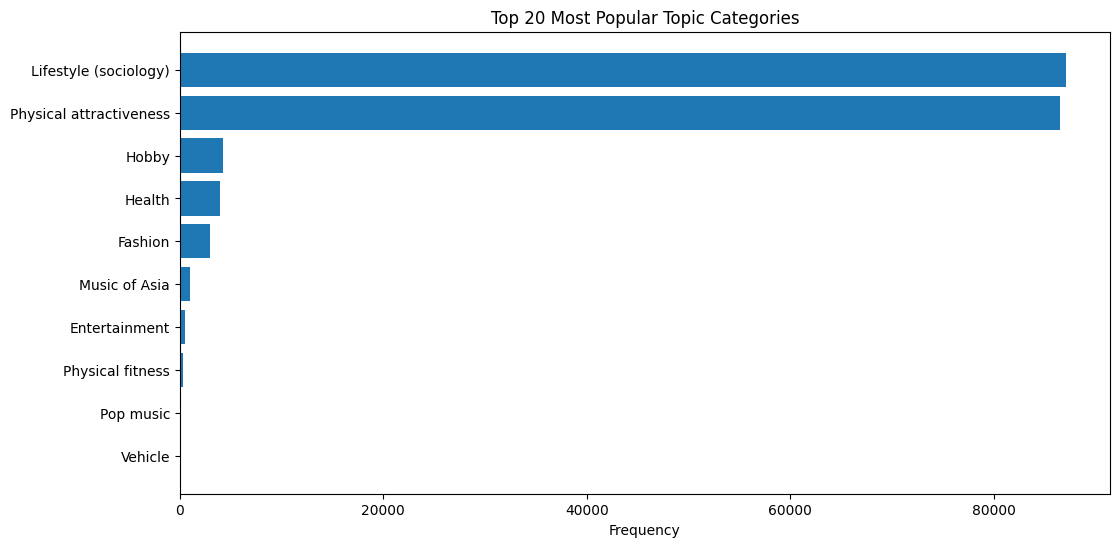

In [ ]:
from collections import Counter
all_topics = [t for sublist in df['topicCleaned'] for t in sublist if isinstance(sublist, list)]
topic_counts = Counter(all_topics)

# Get top 10 categories
top_topics = topic_counts.most_common(10)

# Separate labels and values
labels, values = zip(*top_topics)

# Plot
plt.figure(figsize=(12,6))
plt.barh(labels, values)
plt.xlabel("Frequency")
plt.title("Top 20 Most Popular Topic Categories")
plt.gca().invert_yaxis()  # largest on top
plt.show()

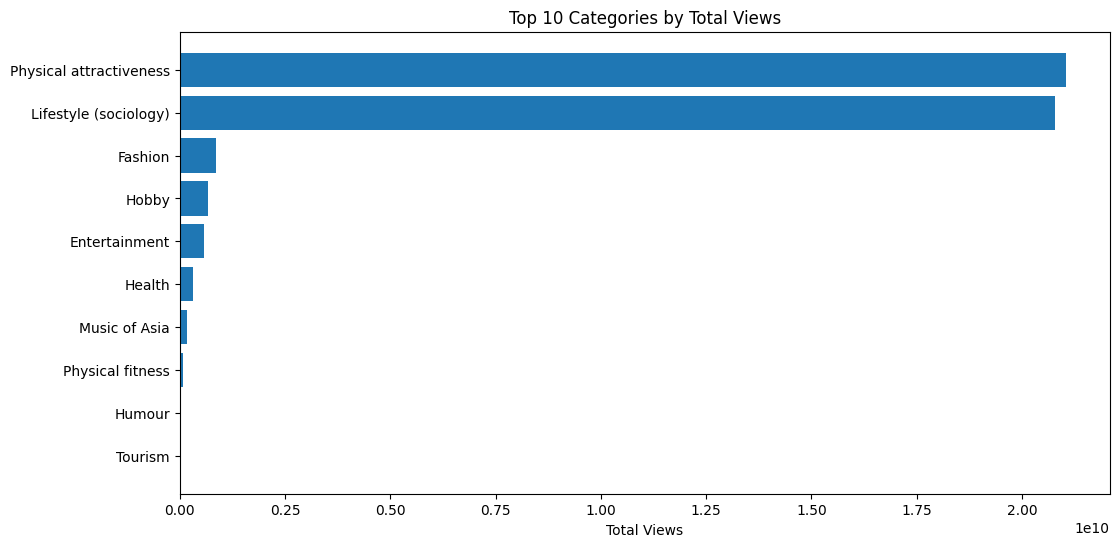

In [ ]:
from collections import defaultdict
category_views = defaultdict(int)

# Sum views per category
for cats, views in zip(df['topicCleaned'], df['viewCount']):
    if not isinstance(cats, list):
        continue
    try:
        v = int(views)
    except Exception:
        v = 0
    for c in cats:
        category_views[c] += v

# Sort and take top 10
top_by_views = sorted(category_views.items(), key=lambda x: x[1], reverse=True)[:10]
labels, values = zip(*top_by_views)

# Plot
plt.figure(figsize=(12,6))
plt.barh(labels, values)
plt.xlabel("Total Views")
plt.title("Top 10 Categories by Total Views")
plt.gca().invert_yaxis()
plt.show()

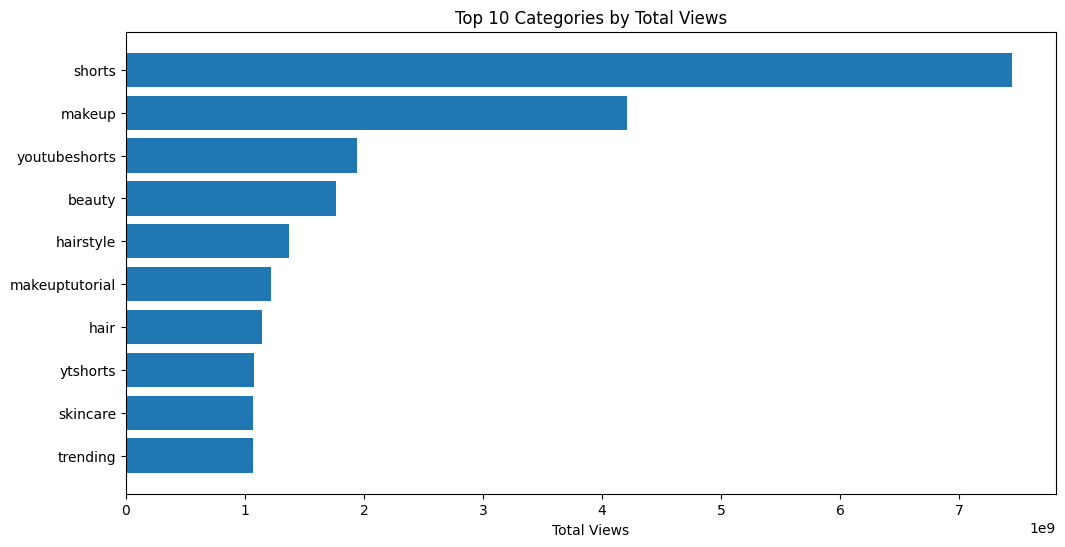

In [ ]:
tags_views = defaultdict(int)

# Sum views per category
for tags, views in zip(df['tags'], df['viewCount']):
    if not isinstance(cats, list):
        continue
    try:
        v = int(views)
    except Exception:
        v = 0
    for t in tags:
        tags_views[t] += v

# Sort and take top 10
top_by_views = sorted(tags_views.items(), key=lambda x: x[1], reverse=True)[:10]
labels, values = zip(*top_by_views)

# Plot
plt.figure(figsize=(12,6))
plt.barh(labels, values)
plt.xlabel("Total Views")
plt.title("Top 10 Categories by Total Views")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
df['upload_month'] = df['publishedAt'].dt.to_period('M').apply(lambda r: r.start_time.date())

/tmp/ipython-input-1688453371.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['upload_month'] = df['publishedAt'].dt.to_period('M').apply(lambda r: r.start_time.date())


/tmp/ipython-input-171908774.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')


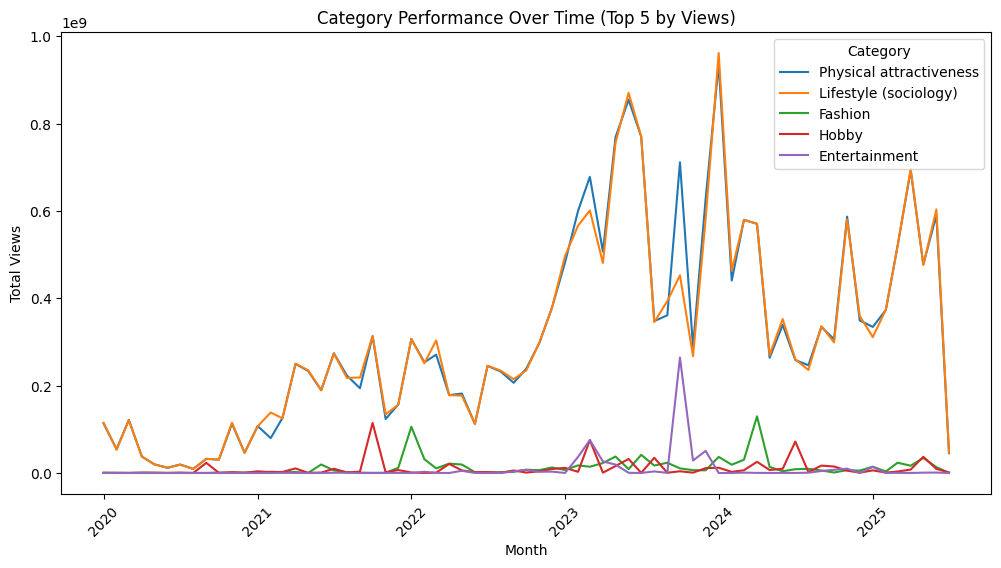

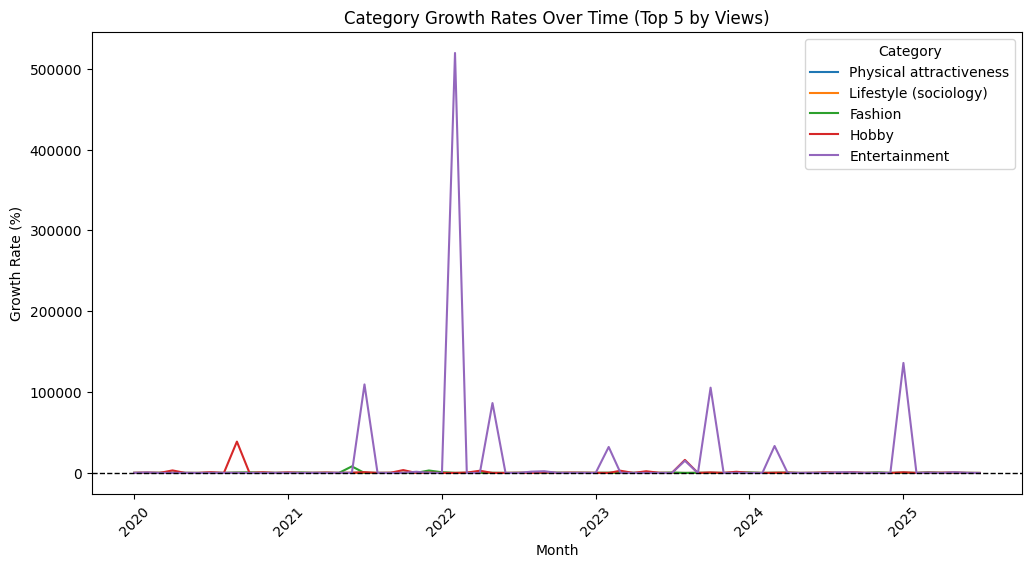

In [ ]:
# Explode categories so each video-category pair becomes its own row
df_exploded = df.explode('topicCleaned')
df_exploded = df_exploded.dropna(subset=['topicCleaned'])

# Group by month and category
df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')
cat_time = (
    df_exploded.groupby(['upload_month','topicCleaned'])['viewCount']
    .sum()
    .reset_index()
)

# Pivot for plotting
cat_pivot = cat_time.pivot(index='upload_month', columns='topicCleaned', values='viewCount').fillna(0)

# Compute growth rate = percentage change month-to-month
cat_growth = cat_pivot.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

# Plot top 5 categories by total views
top5_cats = cat_pivot.sum().sort_values(ascending=False).head(5).index
cat_pivot[top5_cats].plot(figsize=(12,6))
plt.title("Category Performance Over Time (Top 5 by Views)")
plt.ylabel("Total Views")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.show()

# ---- Plot Growth Rates ----
plt.figure(figsize=(12,6))
(cat_growth[top5_cats] * 100).plot(ax=plt.gca())
plt.title("Category Growth Rates Over Time (Top 5 by Views)")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(title="Category")
plt.show()

/tmp/ipython-input-3686110200.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')


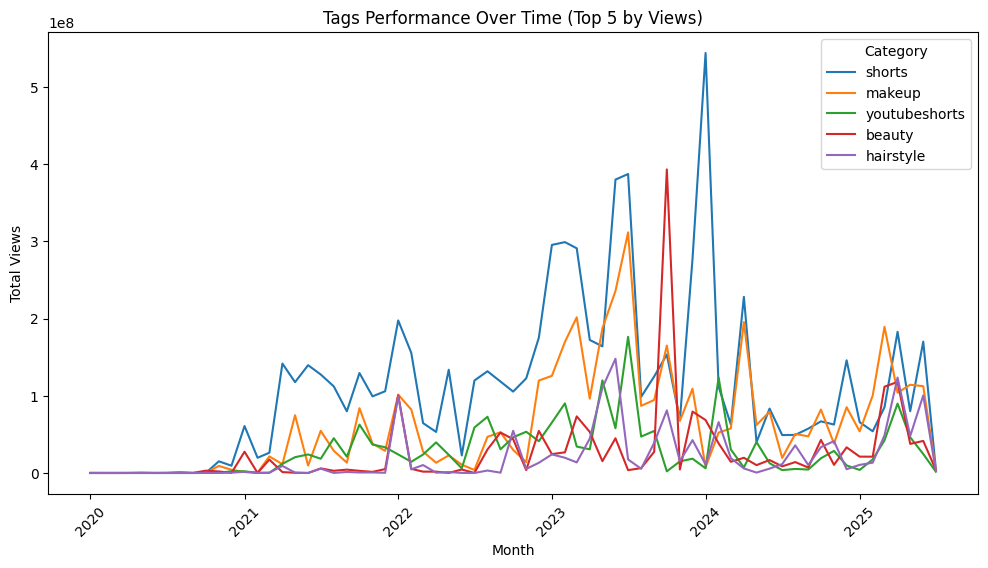

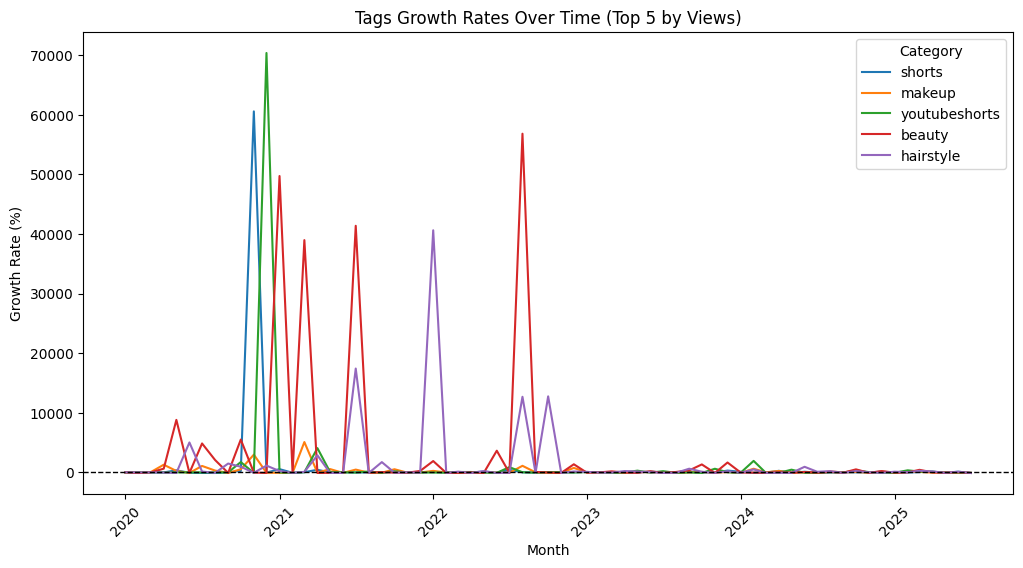

In [ ]:
# Explode categories so each video-category pair becomes its own row
df_exploded = df.explode('tags')
df_exploded = df_exploded.dropna(subset=['tags'])

# Group by month and category
df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')
tag_time = (
    df_exploded.groupby(['upload_month','tags'])['viewCount']
    .sum()
    .reset_index()
)

# Pivot for plotting
tag_pivot = tag_time.pivot(index='upload_month', columns='tags', values='viewCount').fillna(0)

tag_growth = tag_pivot.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

# Plot top 5 tags by total views
top5_tags = tag_pivot.sum().sort_values(ascending=False).head(5).index
tag_pivot[top5_tags].plot(figsize=(12,6))
plt.title("Tags Performance Over Time (Top 5 by Views)")
plt.ylabel("Total Views")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.show()

# ---- Plot Growth Rates ----
plt.figure(figsize=(12,6))
(tag_growth[top5_tags] * 100).plot(ax=plt.gca())
plt.title("Tags Growth Rates Over Time (Top 5 by Views)")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(title="Category")
plt.show()

In [ ]:
# Expand categories
df_exploded = df.explode('topicCleaned').dropna(subset=['topicCleaned'])
df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')

# Aggregate views
cat_time = (
    df_exploded.groupby(['month','topicCleaned'])['viewCount']
    .sum()
    .reset_index()
)

# Pivot into time series
cat_pivot = cat_time.pivot(index='month', columns='topicCleaned', values='viewCount').fillna(0)

entry_decay_points = {}

for cat in cat_pivot.columns:
    series = cat_pivot[cat].astype(float)
    growth = series.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

    entry, decay = None, None

    # Entry: first month with big positive growth (>50% increase over previous month)
    for date, g in growth.items():
        if g > 0.5 and entry is None:
            entry = date
            break

    # Decay: first month after entry with strong decline (< -30%)
    if entry:
        after_entry = growth[series.index >= entry]
        for date, g in after_entry.items():
            if g < -0.3:
                decay = date
                break

    entry_decay_points[cat] = {"entry": entry, "decay": decay}

# Convert to DataFrame for easier inspection
entry_decay_df = (
    pd.DataFrame(entry_decay_points).T
    .reset_index()
    .rename(columns={"index": "category"})
)

print("Entry & Decay Points Detected:")
print(entry_decay_df.head(20))

Entry & Decay Points Detected:
                 category    entry    decay
0             Action game     None     None
1   Action-adventure game     None     None
2              Basketball     None     None
3                Business     None     None
4             Casual game     None     None
5           Country music     None     None
6                 Cricket     None     None
7        Electronic music  2025-06  2025-07
8           Entertainment  2020-02  2020-03
9                 Fashion  2020-04  2020-06
10                   Film  2020-02  2020-03
11                   Food  2025-06  2025-07
12                 Health  2020-02  2020-03
13          Hip hop music  2021-07  2021-08
14                  Hobby  2020-02  2020-03
15                 Humour  2023-01  2023-02
16                   Jazz     None     None
17              Knowledge  2020-02  2020-03
18  Lifestyle (sociology)  2020-03  2020-04
19               Military     None     None


/tmp/ipython-input-3292859334.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')


In [ ]:
print(df_exploded.head(5))

   videoId               publishedAt  channelId  \
0    85806 2024-01-15 00:59:29+00:00      33807   
0    85806 2024-01-15 00:59:29+00:00      33807   
1    30556 2023-10-27 19:32:16+00:00      46650   
1    30556 2023-10-27 19:32:16+00:00      46650   
2    51771 2024-09-28 01:23:22+00:00      14346   

                                               title description  \
0  Unlocking the Benefits of Face Masks for Skin ...         NaN   
0  Unlocking the Benefits of Face Masks for Skin ...         NaN   
1  Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...         NaN   
1  Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...         NaN   
2  #trending #makeup #beautymakeup #yslbeauty #lu...         NaN   

                                                tags defaultLanguage  \
0                                                 []           en-US   
0                                                 []           en-US   
1   [nomakeuplook, hydration, skincare, glowingskin]             NaN

Decay

Preprocess Tags

In [ ]:
import pandas as pd


df_tags = df_exploded.explode("tags")  # each tag becomes its own row
df_tags = df_tags.dropna(subset=["tags"])  # drop empty tags
df_tags = df_tags.rename(columns={"tags": "trend"})  # unify naming
df_tags["trend_type"] = "tag"


Prepare Topics

In [ ]:
df_topics = df_exploded[["videoId", "publishedAt", "viewCount", "topicCleaned"]].copy()
df_topics = df_topics.rename(columns={"topicCleaned": "trend"})
df_topics["trend_type"] = "topic"


Combine Both

In [ ]:
df_trends = pd.concat([df_tags[["videoId", "publishedAt", "viewCount", "trend", "trend_type"]],
                       df_topics[["videoId", "publishedAt", "viewCount", "trend", "trend_type"]]],
                      ignore_index=True)

# Convert publishedAt to datetime
df_trends["publishedAt"] = pd.to_datetime(df_trends["publishedAt"])
df_trends["month"] = df_trends["publishedAt"].dt.to_period("M")


/tmp/ipython-input-1389474116.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_trends["month"] = df_trends["publishedAt"].dt.to_period("M")


Aggregate by Trend & Time

In [ ]:
trend_time = (
    df_trends
    .groupby(["trend_type", "trend", "month"])
    .agg({"viewCount": "sum", "videoId": "nunique"})
    .reset_index()
    .rename(columns={"videoId": "video_count"})
)


In [ ]:
df_trends.head()
df_trends.columns
print(df_trends.head(5))

   videoId               publishedAt  viewCount         trend trend_type  \
0    30556 2023-10-27 19:32:16+00:00      257.0  nomakeuplook        tag   
1    30556 2023-10-27 19:32:16+00:00      257.0     hydration        tag   
2    30556 2023-10-27 19:32:16+00:00      257.0      skincare        tag   
3    30556 2023-10-27 19:32:16+00:00      257.0   glowingskin        tag   
4    30556 2023-10-27 19:32:16+00:00      257.0  nomakeuplook        tag   

     month  
0  2023-10  
1  2023-10  
2  2023-10  
3  2023-10  
4  2023-10  


Trend Decay Identifier

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Decay Identifier ---
def identify_trend_decay(ts, metric_col="viewCount", window=3, drop_threshold=0.3):
    ts = ts.copy()
    # Fix: Convert PeriodDtype to Timestamp if needed
    if isinstance(ts["month"].dtype, pd.PeriodDtype):
        ts["month"] = ts["month"].dt.to_timestamp()
    else:
        ts["month"] = pd.to_datetime(ts["month"])
    ts = ts.sort_values("month")

    # Find peak
    peak_idx = ts[metric_col].idxmax()
    peak_val = ts.loc[peak_idx, metric_col]
    peak_month = ts.loc[peak_idx, "month"]

    ts["phase"] = "Growth"
    ts.loc[ts.index == peak_idx, "phase"] = "Peak"

    decay_start, decay_end = None, None
    decay_score = 0

    after_peak = ts[ts["month"] > peak_month]
    if not after_peak.empty:
        roll_mean = after_peak[metric_col].rolling(window, min_periods=1).mean()

        # sustained decline below threshold
        decline_mask = roll_mean < (peak_val * (1 - drop_threshold))
        if decline_mask.any():
            decay_start = after_peak.loc[decline_mask.idxmax(), "month"]
            decay_end = after_peak["month"].iloc[-1]
            ts.loc[ts["month"] >= decay_start, "phase"] = "Decay"
            decay_score = (peak_val - after_peak[metric_col].iloc[-1]) / peak_val

    return {
        "trend": ts["trend"].iloc[0],
        "trend_type": ts["trend_type"].iloc[0],
        "peak_month": peak_month,
        "peak_value": peak_val,
        "decay_start": decay_start,
        "decay_end": decay_end,
        "decay_score": decay_score
    }, ts


# --- Run Decay Identifier across all trends ---
decay_results = []
all_trends_phases = []

for (trend, trend_type), group in trend_time.groupby(["trend", "trend_type"]):
    result, ts = identify_trend_decay(group)
    decay_results.append(result)
    all_trends_phases.append(ts)

decay_results_df = pd.DataFrame(decay_results)
all_trends_phases_df = pd.concat(all_trends_phases, ignore_index=True)

# --- Updated code to filter out unwanted rows ---
decay_results_df = decay_results_df.loc[
    ~decay_results_df['decay_start'].isna() &
    (decay_results_df['decay_start'] != decay_results_df['decay_end']) &
    (decay_results_df['decay_score'] > 0) &
    (decay_results_df['decay_score'] < 1)
]
#filtering the data to keep only trends that show a real, partial decay over time,
#while removing stable, instantaneous, or non-decaying trends.
print("Decay Results Sample:")
print(decay_results_df.head(10))

Decay Results Sample:
              trend trend_type peak_month  peak_value decay_start  decay_end  \
7                01        tag 2020-04-01     22328.0  2020-06-01 2024-11-01   
18      03007244375        tag 2020-09-01       738.0  2020-10-01 2021-06-01   
29               05        tag 2021-01-01     14428.0  2022-01-01 2022-11-01   
37                1        tag 2024-01-01  21680206.0  2024-02-01 2025-07-01   
38               10        tag 2022-07-01     56922.0  2025-02-01 2025-05-01   
39              100        tag 2022-11-01     14206.0  2023-02-01 2025-06-01   
46   1000subscriber        tag 2023-05-01   1632415.0  2023-12-01 2025-03-01   
57             100k        tag 2023-12-01   4817936.0  2024-10-01 2025-06-01   
90              10k        tag 2022-02-01     30736.0  2023-12-01 2025-06-01   
125              13        tag 2021-07-01     27808.0  2021-11-01 2021-12-01   

     decay_score  
7       0.905769  
18      0.520325  
29      0.207790  
37      0.999821  
38

Visualization

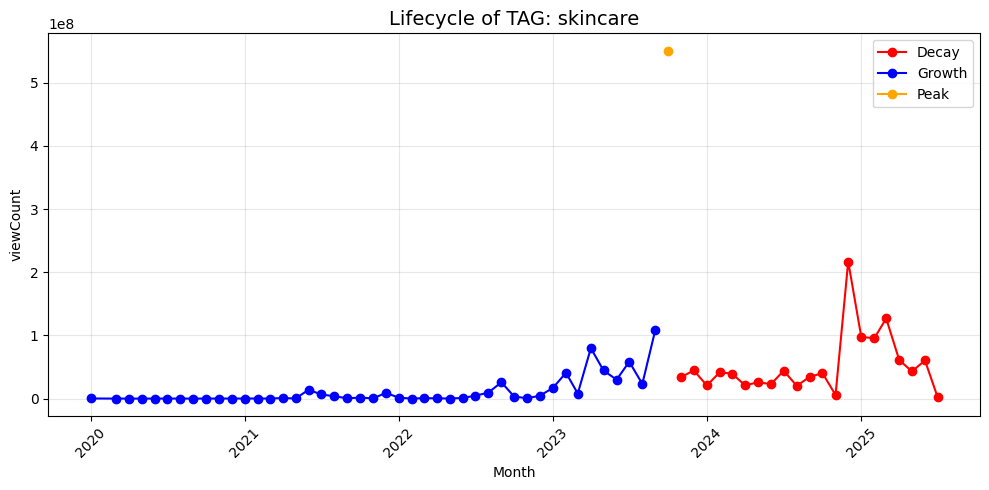

In [ ]:
def plot_trend_lifecycle(ts, trend_name, trend_type, metric_col="viewCount"):
    colors = {"Growth": "blue", "Peak": "orange", "Decay": "red"}

    ts = ts.copy()
    ts["month"] = pd.to_datetime(ts["month"])
    ts = ts.sort_values("month")

    plt.figure(figsize=(10, 5))
    for phase, group in ts.groupby("phase"):
        plt.plot(group["month"], group[metric_col],
                 marker="o", label=phase, color=colors.get(phase, "gray"))

    plt.title(f"Lifecycle of {trend_type.upper()}: {trend_name}", fontsize=14)
    plt.xlabel("Month")
    plt.ylabel(metric_col)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example visualization
sample_trend = "skincare" #can be change by to the trend u want to plot
sample_type = "tag"

sample_ts = all_trends_phases_df[
    (all_trends_phases_df["trend"] == sample_trend) &
    (all_trends_phases_df["trend_type"] == sample_type)
]

plot_trend_lifecycle(sample_ts, trend_name=sample_trend, trend_type=sample_type)




In [ ]:
# Compute decay rate for each trend
decay_results_df["decay_rate"] = decay_results_df["decay_score"].round(3)

decay_results_df = decay_results_df.loc[
    (decay_results_df['decay_rate'] > 0) &
    (decay_results_df['decay_rate'] < 1)
]

# Fastest vs Slowest decaying trends
fastest_decay = decay_results_df.sort_values("decay_rate", ascending=False).head(10)
slowest_decay = decay_results_df.sort_values("decay_rate", ascending=True).head(10)

print("\nTop 10 Fastest Decaying Trends:")
print(fastest_decay[["trend", "trend_type", "decay_rate"]])

print("\nTop 10 Slowest Decaying Trends:")
print(slowest_decay[["trend", "trend_type", "decay_rate"]])



Top 10 Fastest Decaying Trends:
                        trend trend_type  decay_rate
100792                zendaya        tag       0.999
38                         10        tag       0.999
100653               ytshorts        tag       0.999
64731      healthtipsoftheday        tag       0.999
64714             healthgoals        tag       0.999
64821           heatlesscurls        tag       0.999
1226    Action-adventure game      topic       0.999
1118                     ASMR        tag       0.999
65084             highlighter        tag       0.999
64534                   hauls        tag       0.999

Top 10 Slowest Decaying Trends:
                           trend trend_type  decay_rate
14969           MinimalistBeauty        tag       0.001
60493                girlsvsboys        tag       0.002
101101            уходзаволосами        tag       0.005
7058              ExpertStylists        tag       0.006
2017    Attock_Best_Gents_Saloon        tag       0.008
64479          

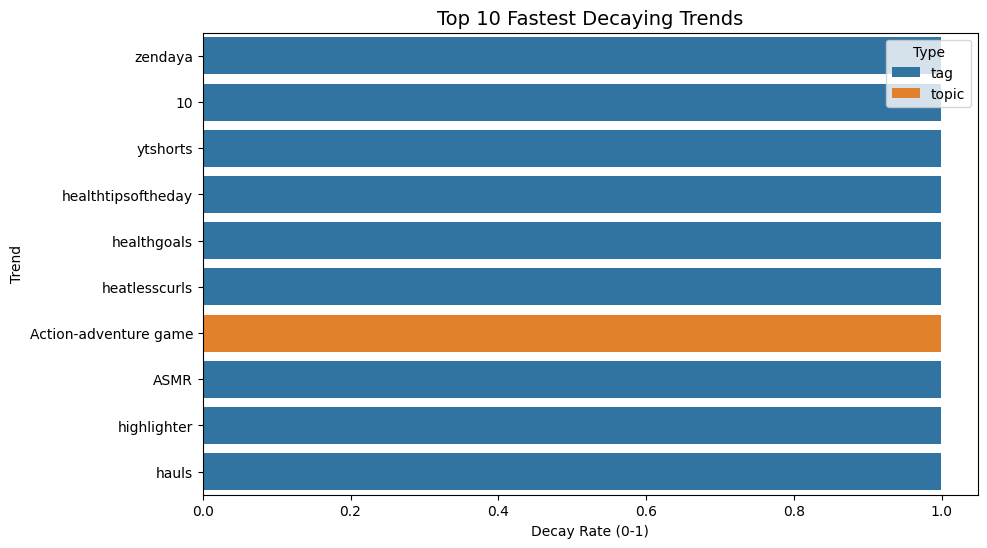

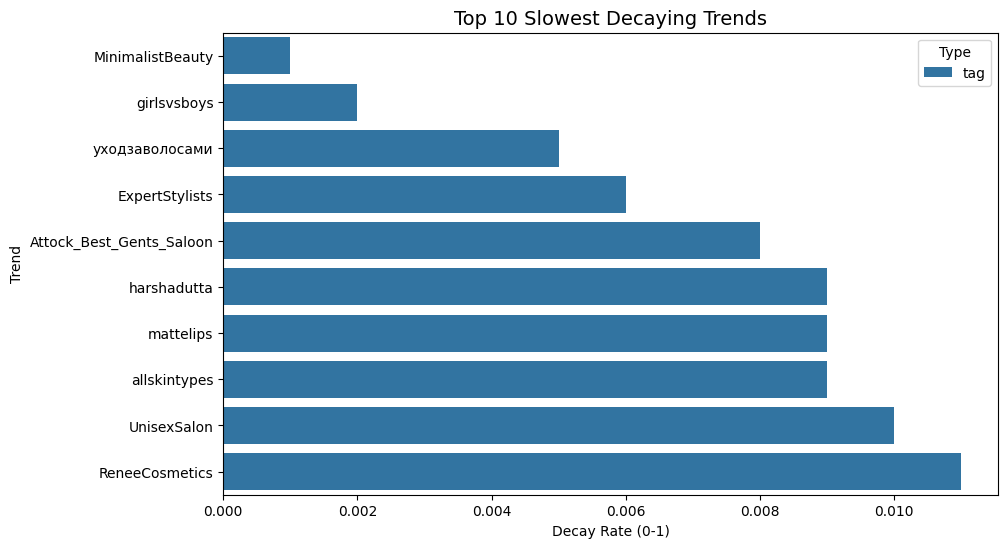

In [ ]:
# Fastest Decay
plt.figure(figsize=(10,6))
sns.barplot(data=fastest_decay, x="decay_rate", y="trend", hue="trend_type")
plt.title("Top 10 Fastest Decaying Trends", fontsize=14)
plt.xlabel("Decay Rate (0-1)")
plt.ylabel("Trend")
plt.legend(title="Type")
plt.show()

# Slowest Decay
plt.figure(figsize=(10,6))
sns.barplot(data=slowest_decay, x="decay_rate", y="trend", hue="trend_type")
plt.title("Top 10 Slowest Decaying Trends", fontsize=14)
plt.xlabel("Decay Rate (0-1)")
plt.ylabel("Trend")
plt.legend(title="Type")
plt.show()



📉 Fastest Decay Example:
trend                      zendaya
trend_type                     tag
peak_month     2022-02-01 00:00:00
peak_value              54028798.0
decay_start    2022-09-01 00:00:00
decay_end      2025-06-01 00:00:00
decay_score               0.999128
decay_rate                   0.999
Name: 100792, dtype: object


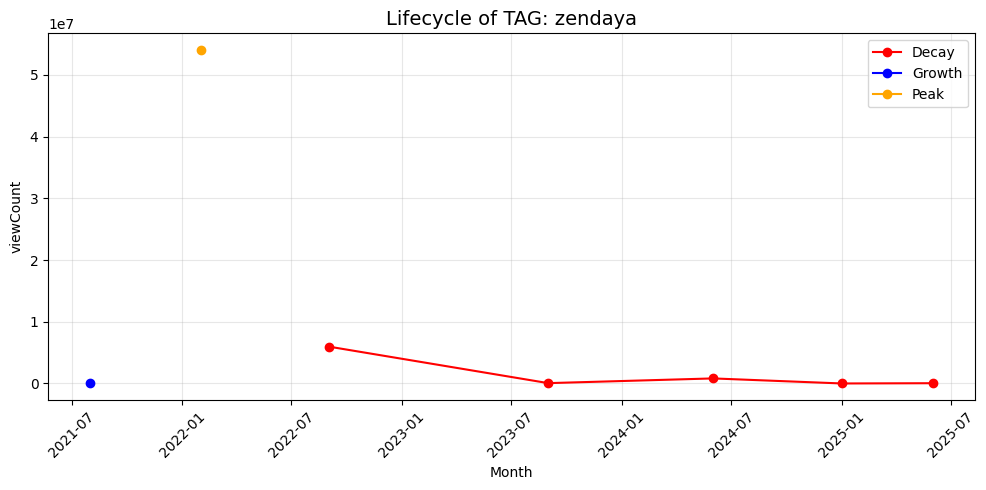


📈 Slowest Decay Example:
trend             MinimalistBeauty
trend_type                     tag
peak_month     2024-12-01 00:00:00
peak_value                  2070.0
decay_start    2025-01-01 00:00:00
decay_end      2025-04-01 00:00:00
decay_score               0.000966
decay_rate                   0.001
Name: 14969, dtype: object


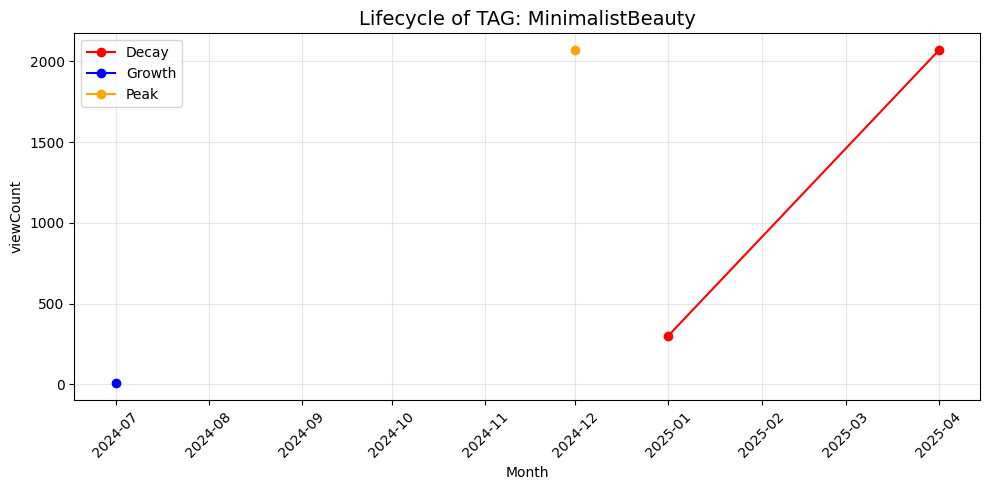

In [ ]:
# Example: fastest and slowest decay showcase
example_fastest = fastest_decay.iloc[0]
example_slowest = slowest_decay.iloc[0]

print("\n📉 Fastest Decay Example:")
print(example_fastest)

plot_trend_lifecycle(
    all_trends_phases_df[(all_trends_phases_df["trend"] == example_fastest["trend"]) &
                         (all_trends_phases_df["trend_type"] == example_fastest["trend_type"])],
    example_fastest["trend"], example_fastest["trend_type"]
)

print("\n📈 Slowest Decay Example:")
print(example_slowest)

plot_trend_lifecycle(
    all_trends_phases_df[(all_trends_phases_df["trend"] == example_slowest["trend"]) &
                         (all_trends_phases_df["trend_type"] == example_slowest["trend_type"])],
    example_slowest["trend"], example_slowest["trend_type"]
)
